In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

# data = load_data("../stats/fpm_2_closed_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_open_solver_1_numba.json")
# data = load_data("../stats/fpm_2_closed_m_sliding_solver_1_numba.json")

# data = load_data("../stats/fpm_0_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_0_sliding_solver_1_numba.json")
# data = load_data("../stats/fpm_0_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_solver_1_numba.json")
# data = load_data("../stats/fpm_1_sliding_solver_1_numba.json")
data = load_data("../stats/fpm_1_open_solver_1_numba.json")

# data = load_data("../stats/fpm_01_open_solver_1_numba.json")

# data = load_data("../stats/fpm_1_sticking_direct_numba.json")

In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
# from fpm_2_closed_m import make_model
# from fpm_2_closed import make_model
# from fpm_0 import make_model
# from fpm_01 import make_model
from fpm_1 import make_model
# from fpm_1_m import make_model


from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)


# model.assemble_linear_system()
# mat, rhs = model.linear_system

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


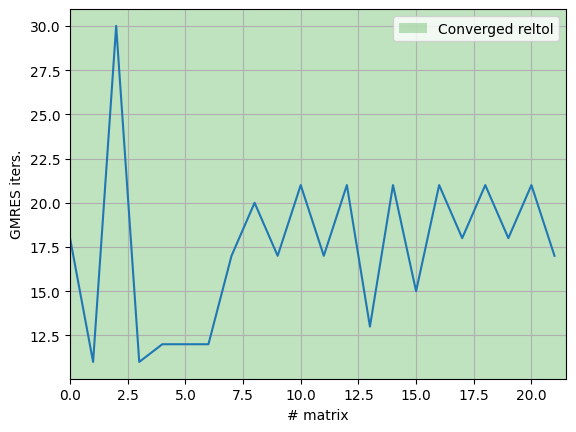

In [3]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [4]:
mat_idx = 10
get_gmres_iterations(data)[mat_idx]

21

In [5]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
transition = get_num_transition_cells(data)
sticking = sticking[mat_idx]
sliding = sliding[mat_idx]
open_ = open_[mat_idx]
transition = int(transition[mat_idx])
total = sticking + sliding + open_
print(f'{sticking = }', f'{sliding = }', f'open = {open_}', f'{transition = }', f'{total = }', sep='\n')

sticking = 48
sliding = 0
open = 24
transition = 72
total = 72


In [6]:
from plot_utils import *

mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(data, mat_idx)

# model.time_manager.dt = dt
# model.before_nonlinear_loop()
# model.before_nonlinear_iteration()
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.rediscretize()
# model.assemble_linear_system()

# assert (model.linear_system[0] - mat).data.size == 0
# assert np.all(model.linear_system[1] == rhs)

# mat, rhs = model.linear_system

mat = mat[reorder]
rhs = rhs[reorder]

Solve  took: 0.24


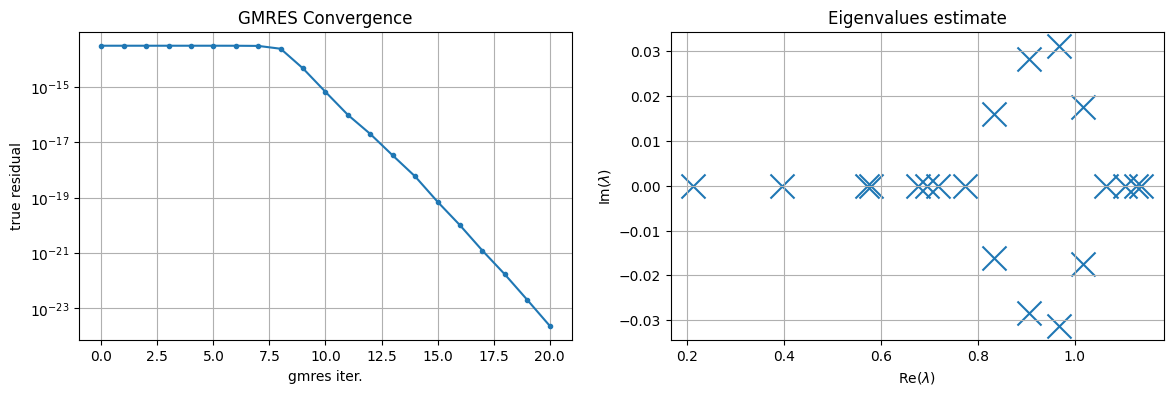

In [7]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(state, iterate_index=0)
perm_mat, prec_orig = model._prepare_solver()
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

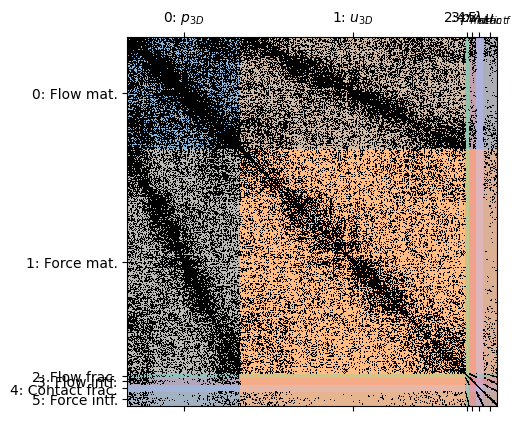

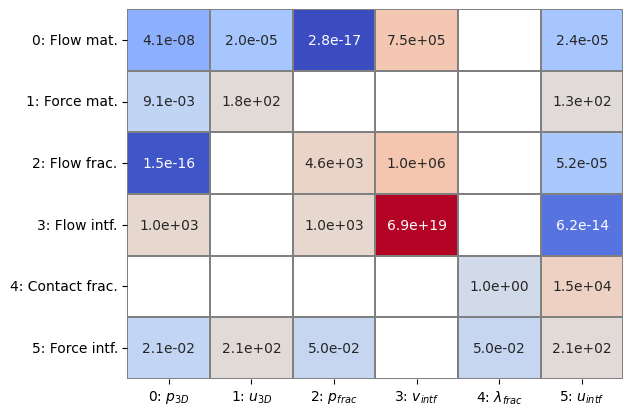

In [8]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)
    
J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    # group_row_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{2D}$', r'$u_{2D}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']

    # group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    # group_col_names=[r'$p_{3D}$', r'$u_{3D}$', '', '', '', '']

    group_row_names=[r'Flow mat.', r'Force mat.', r'Flow frac.', r'Flow intf.', r'Contact frac.', 'Force intf.'],
    group_col_names=[r'$p_{3D}$', r'$u_{3D}$', r'$p_{frac}$', r'$v_{intf}$', r'$\lambda_{frac}$', '$u_{intf}$']
)
# plt.figure(figsize=(8, 8))
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

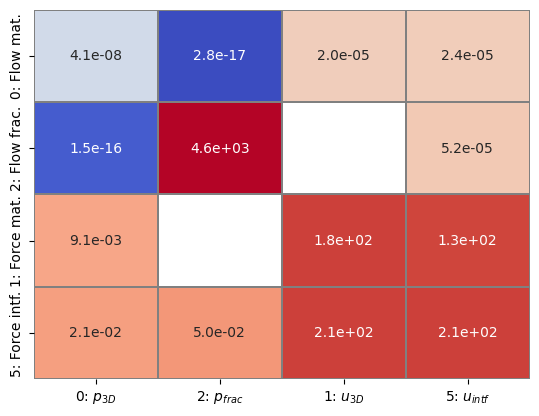

In [9]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)

schema = SolveSchema(
    groups=[3],
    solve=lambda bmat: extract_diag_inv(bmat.mat),
    complement=SolveSchema(
        groups=[4],
        solve=lambda bmat: make_J44_inv_bdiag(model=model, bmat=J),
        complement=SolveSchema(groups=[0, 2, 1, 5], solve=lambda bmat: bmat.mat),
    ),
)

mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
mat_permuted[[0, 2, 1, 5]].plot_max()

# Test only mechanics

Solve  took: 0.06


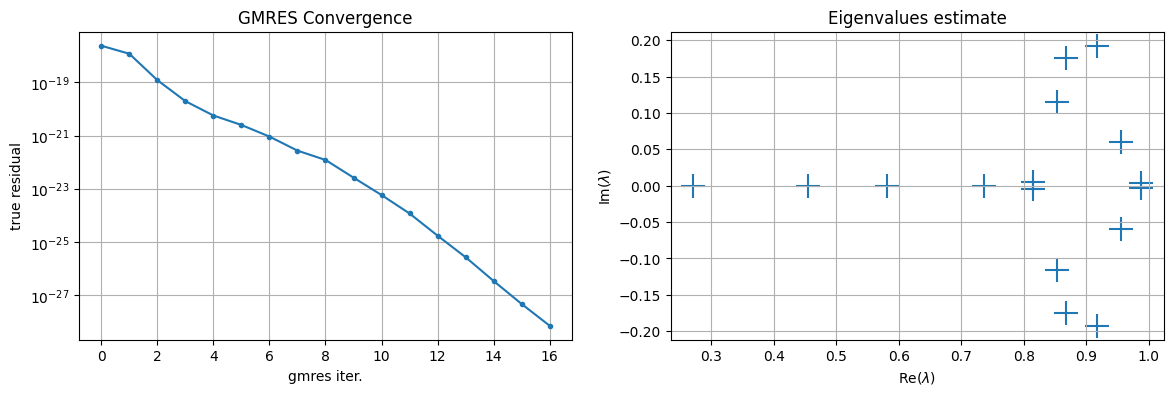

In [10]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv, make_J44_inv_bdiag

schema15_amg = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model=model, bmat=J),
    complement=schema15_amg,
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec_good, rhs=mat_permuted.local_rhs(rhs))

# Test full system

* fails for `fpm_01`
* fails for `fpm_1`

Solve  took: 0.5
PETSc Converged Reason: -5
lambda min: 0.21581351319444483


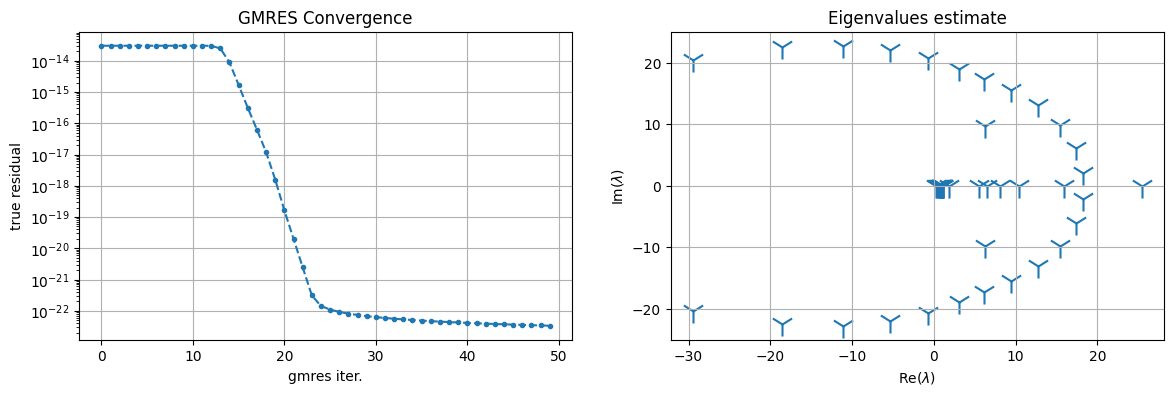

In [11]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv


schema = SolveSchema(
    groups=[3],
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # solve=lambda bmat: PetscILU(bmat.mat),
    # solve=lambda bmat: make_J44_inv(model=model, bmat=J, lump=True),
    complement=SolveSchema(
        groups=[4, 5],
        complement=SolveSchema(
            groups=[1],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
            invertor_type='physical',
            invertor=lambda: get_fixed_stress_stabilization_nd(model),
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            )
        ),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

# Making new fixed stress

This takes 24 seconds for `fpm_1`

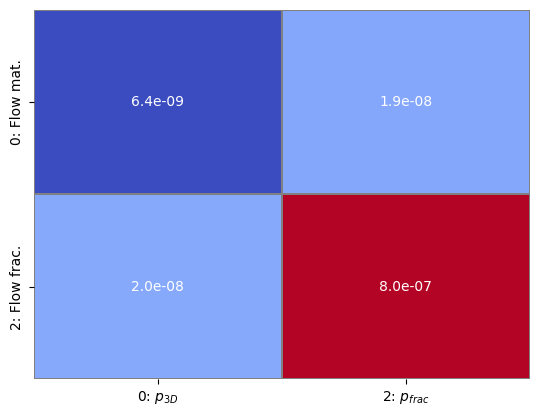

In [12]:
def make_S22_bdiag(model, bmat: BlockMatrixStorage):
    elim = [1,5]
    keep = [0,2]

    # Jelim_bdiag_inv = inv_block_diag(bmat[elim, elim].mat, nd=model.nd)
    Jelim_bdiag_inv = inv(bmat[elim, elim].mat)
    Skeep = - bmat[keep, elim].mat @ Jelim_bdiag_inv @ bmat[elim, keep].mat
    
    return Skeep

tmp = J[[0,2]]
tmp.mat = make_S22_bdiag(model, J)
tmp.plot_max()

In [13]:
sticking, sliding, open_ = get_sticking_sliding_open(data, idx=mat_idx)
open_

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True, False, False, False,  True,  True,  True])

Below shows that the preconditioner must affect open cells

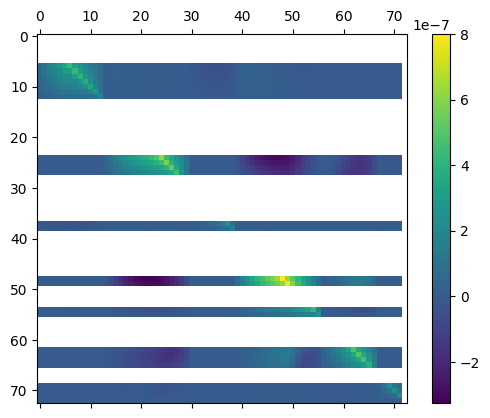

In [14]:
tmp[2, 2].matshow(log=False)

## Naive FS approach

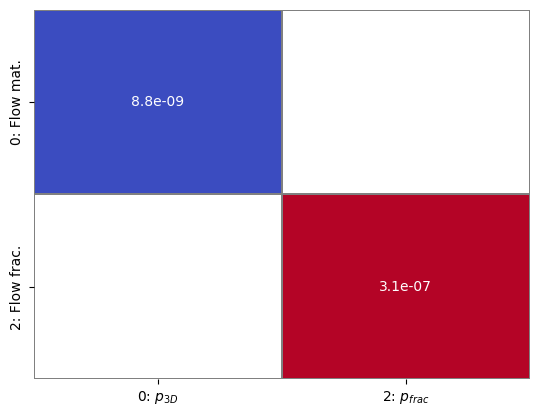

In [45]:
def make_frac_to_mat_cells(model):

    matrix = model.mdg.subdomains(dim=2)[0]
    fractures = model.mdg.subdomains(dim=1)

    faces_to_cells = matrix.cell_faces.T.tocsc()
    faces_to_cells.eliminate_zeros()

    mat_list = []
    for frac in fractures:
        intfs = model.mdg.subdomain_to_interfaces(sd=frac)
        intf = intfs[0]
        assert all(intf.dim < frac.dim for intf in intfs[1:])

        secondary_to_mortar = intf.secondary_to_mortar_avg().tocsc()
        mortar_to_primary = intf.mortar_to_primary_avg().tocsc()
        # sign_to_mortar_side = intf.sign_of_mortar_sides().diagonal()
        secondary_to_mortar.eliminate_zeros()
        mortar_to_primary.eliminate_zeros()
        faces_to_cells.eliminate_zeros()


        frac_to_mat_cells = faces_to_cells @ mortar_to_primary @ secondary_to_mortar

        mat_list.append(frac_to_mat_cells)

    mat = bmat([mat_list], format="csr").T
    return mat


import scipy.sparse


def make_S22_bdiag(model, bmat: BlockMatrixStorage):
    mu_lame = model.solid.shear_modulus()
    lambda_lame = model.solid.lame_lambda()
    alpha_biot = model.solid.biot_coefficient()
    l_factor = 0.6
    dt = model.time_manager.dt
    max_dim = model.nd

    l_phys = alpha_biot**2 / (2 * mu_lame / max_dim + lambda_lame)
    l_min = alpha_biot**2 / (4 * mu_lame + 2 * lambda_lame)
    val = l_min * (l_phys / l_min) ** l_factor

    subdomains = [sd for dim in [2, 1, 0] for sd in model.mdg.subdomains(dim=dim)]

    fixed_stress = np.concatenate([sd.cell_volumes for sd in subdomains])
    fixed_stress *= val

    density = model.fluid_density(subdomains).value(model.equation_system)
    fixed_stress *= density
    fixed_stress /= dt

    result = scipy.sparse.diags(fixed_stress).tocsr()
    return result

def get_fixed_stress_stabilization_nd_new(model, bmat):
    frac_to_mat = make_frac_to_mat_cells(model)
    mat_to_frac = frac_to_mat.T
    ones_mat = csr_ones(mat_to_frac.shape[0])
    ones_frac = csr_ones(mat_to_frac.shape[1])

    contribution_0d = csr_zeros(sum(sd.num_cells for sd in model.mdg.subdomains(dim=0)))

    # Below can change something!
    local_02 = scipy.sparse.bmat([
        [ones_mat, None, None],
        [None, ones_frac, None],
        [None, None, contribution_0d]
    ], format='csr')

    fs = make_S22_bdiag(model, bmat)
    res =  fs @ local_02
    return res


tmp = J[[0,2]]
tmp.mat = get_fixed_stress_stabilization_nd_new(model, J)
tmp.plot_max()

Solve  took: 0.35


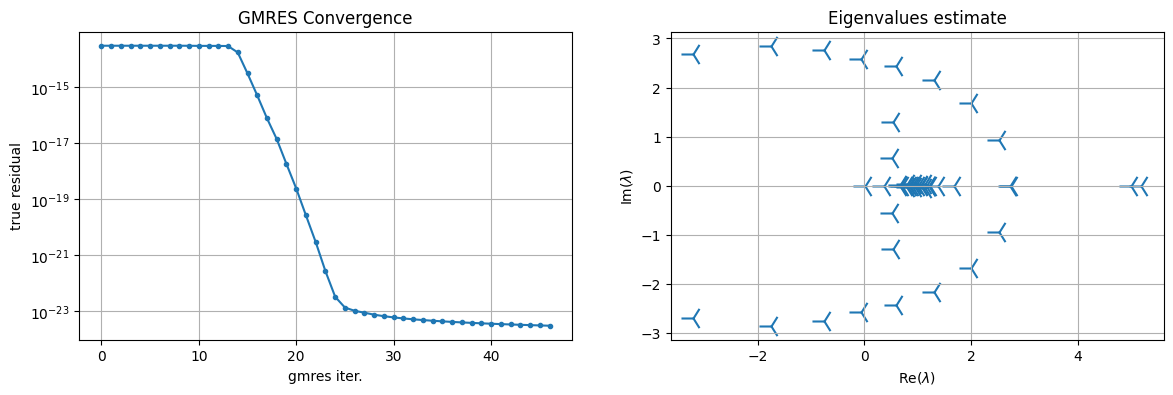

In [44]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization, get_fixed_stress_stabilization_nd
from preconditioner_mech import (
    build_mechanics_stabilization,
    make_J44_inv,
    make_J44_inv_bdiag,
)


schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor_type="physical",
    # invertor=lambda bmat: get_fixed_stress_stabilization(model),
    # invertor=lambda bmat: get_fixed_stress_stabilization_nd(model),
    invertor=lambda bmat: get_fixed_stress_stabilization_nd_new(model, bmat),
    # invertor=lambda bmat: make_S22_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
# solve(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
# plt.suptitle('Naive FS 1 frac')

## Test vector approach

Below shows that it works without fractures

Solve  took: 0.12


Text(0.5, 0.98, 'test_vector no fractures')

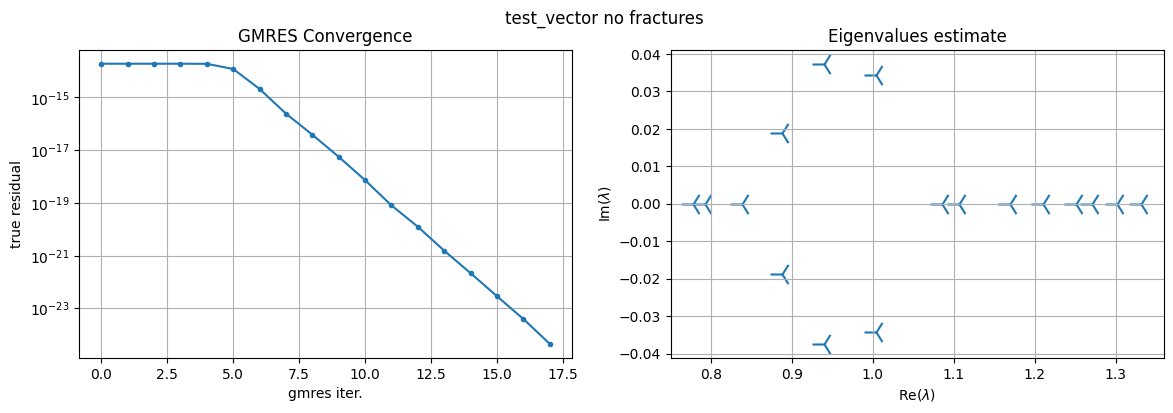

In [17]:
schema = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor_type="test_vector",
    complement=SolveSchema(
        groups=[0],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
plt.suptitle('test_vector no fractures')

Undrained splitting

Solve  took: 0.1


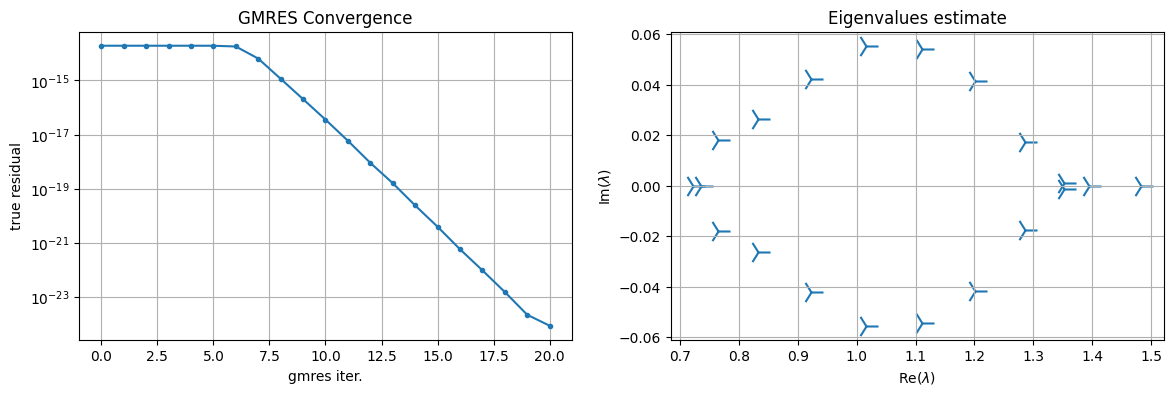

In [18]:
schema = SolveSchema(
    groups=[0],
    solve=lambda bmat: PetscAMGFlow(bmat.mat),
    invertor_type="test_vector",
    complement=SolveSchema(
        groups=[1],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Reference: Physics based FS

Solve  took: 0.09


Text(0.5, 0.98, 'FS no fractures')

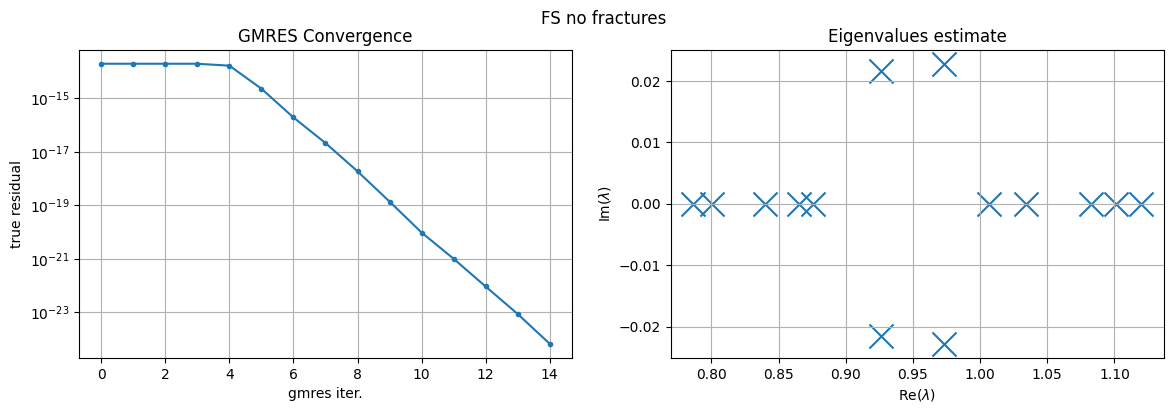

In [19]:
schema = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda: get_fixed_stress_stabilization(model),
    invertor_type="physical",
    complement=SolveSchema(
        groups=[0],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
plt.suptitle('FS no fractures')

It works with fractures as well! But not so good as the naive FS.
* works well for `fpm_01`
* more than 150 iters for `fpm_1`

Solve  took: 1.3
PETSc Converged Reason: -5
lambda min: 0.34709221313600447


Text(0.5, 0.98, 'test_vector with fractures')

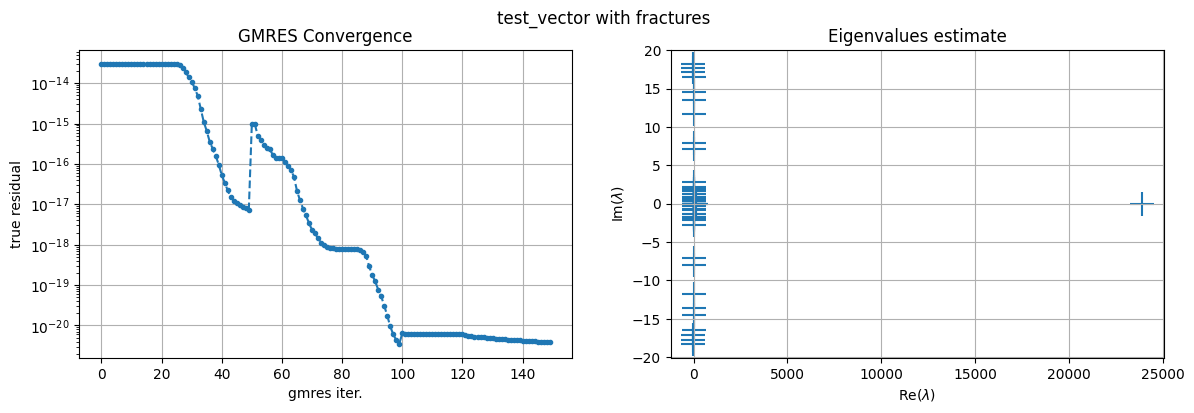

In [20]:
schema = SolveSchema(
    invertor_type="test_vector",
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    # only_complement=True,
    complement=SolveSchema(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))
plt.suptitle('test_vector with fractures')

2x2 vector test?

# Franceschini-style approach

In [21]:
from dataclasses import dataclass

@dataclass
class Connectivity:
    dim: int
    frac_idx: int

    frac_local_ids: np.ndarray[int]
    intf_local_ids: np.ndarray[int]
    mat_local_ids: np.ndarray[int]

    frac_offset: int
    intf_offset: int


In [22]:
from porepy.numerics.linalg.matrix_operations import sparse_kronecker_product


def make_connectivity_list(model, dim: int) -> list[Connectivity]:
    matrix = model.mdg.subdomains(dim=model.nd)[0]
    fractures = model.mdg.subdomains(dim=model.nd - 1)

    faces_to_cells = sparse_kronecker_product(matrix.cell_faces.T, nd=dim).tocsc()
    faces_to_cells.eliminate_zeros()

    connectivity_list: list[Connectivity] = []

    frac_offset = 0
    intf_offset = 0

    for frac_idx, frac in enumerate(fractures):
        intfs = model.mdg.subdomain_to_interfaces(sd=frac)
        intf = intfs[0]
        assert all(intf.dim < frac.dim for intf in intfs[1:])

        secondary_to_mortar = intf.secondary_to_mortar_avg(nd=dim).tocsc()
        mortar_to_primary = intf.mortar_to_primary_avg(nd=dim).tocsc()
        # sign_to_mortar_side = intf.sign_of_mortar_sides().diagonal()
        secondary_to_mortar.eliminate_zeros()
        mortar_to_primary.eliminate_zeros()
        faces_to_cells.eliminate_zeros()

        for i in range(frac.num_cells):
            frac_local_ids = np.arange(i * dim, (i + 1) * dim)
            intf_local_ids = secondary_to_mortar[:, frac_local_ids].indices
            face_local_ids = mortar_to_primary[:, intf_local_ids].indices
            mat_local_ids = faces_to_cells[:, face_local_ids].indices

            connectivity_list.append(
                Connectivity(
                    dim=dim,
                    frac_idx=frac_idx,
                    frac_local_ids=frac_local_ids,
                    intf_local_ids=intf_local_ids,
                    mat_local_ids=mat_local_ids,
                    frac_offset=frac_offset,
                    intf_offset=intf_offset,
                )
            )
        
        frac_offset += frac.num_cells
        intf_offset += intf.num_cells
    return connectivity_list

connectivity_list = make_connectivity_list(model, dim=2)

connectivity = connectivity_list[0]
connectivity

Connectivity(dim=2, frac_idx=0, frac_local_ids=array([0, 1]), intf_local_ids=array([ 0, 12,  1, 13], dtype=int32), mat_local_ids=array([4198,  996, 4199,  997], dtype=int32), frac_offset=0, intf_offset=0)

In [23]:
def assemble_localization_matrices(
    model, bmat: BlockMatrixStorage, groups: dict[int, Literal["mat", "intf", "frac"]]
):
    connectivity_list = make_connectivity_list(model, dim=2)
    localisazation_matrices = []

    groups_used = list(groups.keys())
    local_bmat = bmat[groups_used]

    group_offsets = []
    tmp = 0
    for group in groups_used:
        group_offsets.append(tmp)
        tmp += local_bmat[[group]].shape[0]

    for connectivity in connectivity_list:
        indices = []
        for group_local_idx, group_type in enumerate(groups.values()):
            group_offset = group_offsets[group_local_idx]
            if group_type == "mat":
                indices.extend(connectivity.mat_local_ids + group_offset)
            elif group_type == "frac":
                indices.extend(
                    connectivity.frac_local_ids
                    + connectivity.frac_offset
                    + group_offset
                )
            elif group_type == "intf":
                indices.extend(
                    connectivity.intf_local_ids
                    + connectivity.intf_offset
                    + group_offset
                )
            else:
                raise ValueError(group_type)

        col_idx = np.array(indices)
        data = np.ones_like(indices)
        row_idx = np.arange(col_idx.size)
        localization = scipy.sparse.csr_matrix(
            (data, (row_idx, col_idx)), shape=(col_idx.size, local_bmat.shape[1])
        )
        localisazation_matrices.append(localization)

    return localisazation_matrices

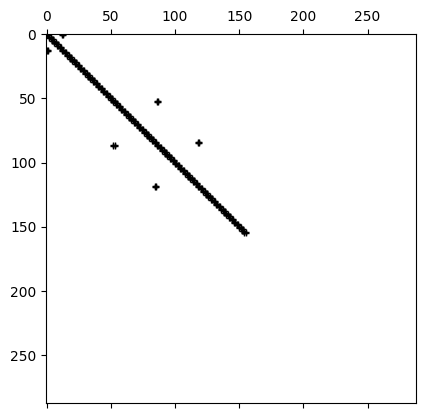

In [24]:
J15 = J[[5]].mat
J15_inv = csr_zeros(J15.shape[0])

localization_mats = assemble_localization_matrices(
    model,
    J,
    groups={
        # 1: "mat",
        5: "intf",
    },
)

for R in localization_mats:
    j15 = R @ J15 @ R.T
    j15_inv = inv(j15)
    J15_inv += R.T @ j15_inv @ R

spy(J15_inv, marker='+')

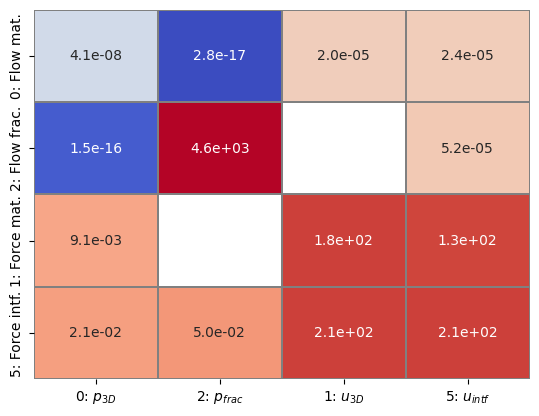

In [25]:
J[[0,2,1,5]].plot_max()

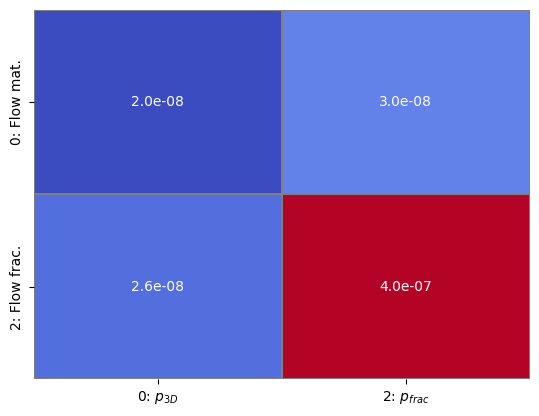

In [46]:
def build_prec() -> BlockMatrixStorage:
    localization_mats = assemble_localization_matrices(
        model,
        J,
        groups={
            1: "mat",
            5: "intf",
        },
    )

    elim = [1, 5]
    keep = [0, 2]

    mat = J[elim].mat
    J15_inv = csr_zeros(mat.shape[0])

    for R in localization_mats:
        j15 = R @ mat @ R.T
        j15_inv = inv(j15)
        J15_inv += R.T @ j15_inv @ R

    Jek = J[elim, keep].mat
    Jke = J[keep, elim].mat
    stab = J[keep].copy()
    stab.mat = - Jke @ J15_inv @ Jek

    # stab[0, 0] = stab[0, 0].mat + get_fixed_stress_stabilization(model)
    stab.mat += get_fixed_stress_stabilization_nd_new(model, J)

    return stab


tmp = build_prec()
tmp.plot_max()

Solve  took: 0.23


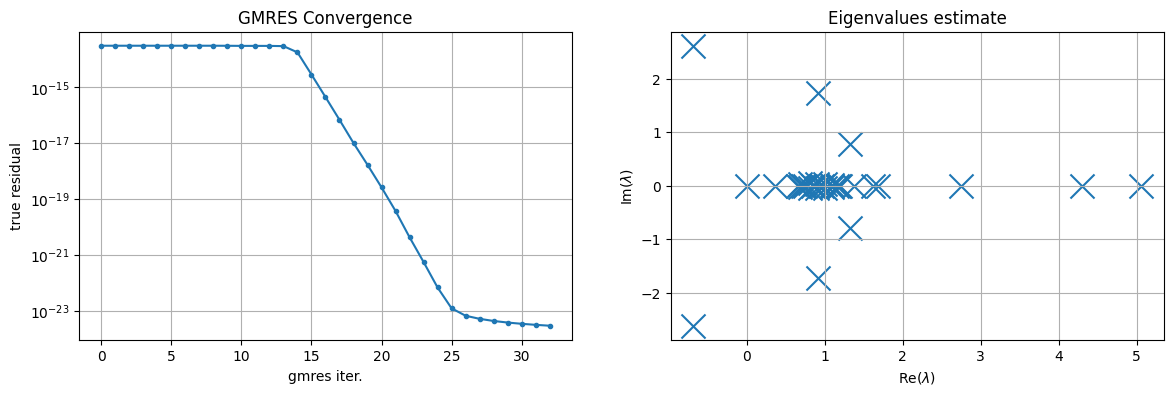

In [48]:
schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(mat=bmat.mat, dim=model.nd),
    invertor=lambda bmat: build_prec().mat,
    invertor_type='physical',
    
    # only_complement=True,
    complement=SolveSchema(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(bmat.mat),
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))